In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn')
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

# Begin importing data

In [2]:
files = ["stage_2", "stage_3", "stage_4", "playoffs"]

df = pd.read_csv("data/phs_2018_stage_1.csv")
for f in files:
    df = df.append(pd.read_csv("data/phs_2018_" + f + ".csv"))

files.insert(0, "stage_1")
for f in files:
    df = df.append(pd.read_csv("data/phs_2019_" + f + ".csv").rename(columns={"pelstart_time":'start_time'}))
df = df.append(pd.read_csv('data/phs_2020_1.csv').rename(columns={"hero_name":'hero',"team_name":"team","player_name":"player","esports_match_id":"match_id","tournament_title":"stage"}))
df = df.append(pd.read_csv('data/phs_2020_2.csv').rename(columns={"hero_name":'hero',"team_name":"team","player_name":"player","esports_match_id":"match_id","tournament_title":"stage"}))
df = df.append(pd.read_csv('data/phs_2021_1.csv').rename(columns={"hero_name":'hero',"team_name":"team","player_name":"player","esports_match_id":"match_id","tournament_title":"stage"}))

In [3]:
map_df = pd.read_csv("data/match_map_stats.csv", index_col="match_id")

# Create some boolean masks

In [4]:
widow = df["hero"] == "Widowmaker"
mccree = df["hero"] == "McCree"
ashe = df["hero"] == "Ashe"
hanzo = df["hero"] == "Hanzo"
allHeros = df["hero"] == "All Heroes"
damageDone = df["stat_name"] == "All Damage Done"
weapAcc = df["stat_name"] == "Weapon Accuracy"
kills = df["stat_name"] == "Eliminations"
timePlayed = df["stat_name"] == "Time Played"
weapAcc = df["stat_name"] == "Weapon Accuracy"
kills = df["stat_name"] == "Eliminations"


# Create win dataframe


In [5]:
match_win = map_df[['match_winner']]
match_win = match_win[~match_win.index.duplicated(keep='first')]
df_match = df.set_index('match_id')
df_match_player = df[allHeros & timePlayed].set_index('match_id')
df_win = pd.merge(df_match_player, match_win, left_index=True, right_index=True)
df_complete = pd.merge(df_match, match_win, left_index=True, right_index=True)   

In [6]:
def win_lose(x,y):
    if (x == y):
        return 'win'
    else:
        return 'lose'
        
df_win["match_result"] = df_win[["team","match_winner"]].apply(lambda x : win_lose(*x), axis=1)
df_complete["match_result"] = df_complete[["team","match_winner"]].apply(lambda x : win_lose(*x), axis=1)

In [19]:
df_complete[timePlayed_c]

,start_time,stage,map_type,map_name,player,team,stat_name,hero,stat_amount,match_winner,match_result
match_id,,,,,,,,,,,
10223,1/11/2018 0:12,Overwatch League - Stage 1,PAYLOAD,Dorado,Agilities,Los Angeles Valiant,Time Played,All Heroes,836.332770,Los Angeles Valiant,win
10223,1/11/2018 0:12,Overwatch League - Stage 1,PAYLOAD,Dorado,Agilities,Los Angeles Valiant,Time Played,Genji,836.332770,Los Angeles Valiant,win
10223,1/11/2018 0:12,Overwatch League - Stage 1,PAYLOAD,Dorado,Envy,Los Angeles Valiant,Time Played,All Heroes,836.332770,Los Angeles Valiant,win
10223,1/11/2018 0:12,Overwatch League - Stage 1,PAYLOAD,Dorado,Envy,Los Angeles Valiant,Time Played,D.Va,836.332770,Los Angeles Valiant,win
10223,1/11/2018 0:12,Overwatch League - Stage 1,PAYLOAD,Dorado,Fate,Los Angeles Valiant,Time Played,All Heroes,836.332770,Los Angeles Valiant,win
...,...,...,...,...,...,...,...,...,...,...,...
37392,2021-05-08 05:01:45,OWL 2021,PAYLOAD,Havana,Yaki,Florida Mayhem,Time Played,Mei,361.113480,Florida Mayhem,win
37392,2021-05-08 05:01:45,OWL 2021,PAYLOAD,Havana,Yaki,Florida Mayhem,Time Played,Tracer,320.176485,Florida Mayhem,win
37392,2021-05-08 05:01:45,OWL 2021,PAYLOAD,Havana,bqb,Florida Mayhem,Time Played,All Heroes,1170.835146,Florida Mayhem,win


At least 1 min and at least 10 wins

In [36]:
df_win_percent = df_complete[timePlayed_c]
df_win_percent = df_win_percent[(df_win_percent['stat_amount'] >= 60)]
df_win_percent = pd.pivot_table(df_win_percent, index=["map_name","hero"], columns=['match_result'], aggfunc='size')
df_win_percent["Win Percent"] = df_win_percent.apply(
        lambda x: x["win"] / (x["lose"]+x["win"]) * 100, axis="columns")
df_win_percent.to_csv(r'data/win_percent_data.csv')

In [71]:
df_win_players = df_win[["player","match_result","team"]].reset_index()
df_win_team = df_win[["match_result","team"]].reset_index().drop_duplicates(keep="first").set_index(["match_id",'team'])
df_win_players = df_win_players.drop_duplicates(keep="first").set_index(["match_id",'team'])
df_win_players = pd.pivot_table(df_win_players.reset_index(), index=['match_id','team'], values=['player'], aggfunc='size').to_frame()
df_win_subs = pd.merge(df_win_players, df_win_team, left_index=True, right_index=True)


In [73]:
df_win_subs.columns = ['player_count', 'match_result']
df_win_subs = df_win_subs[df_win_subs["player_count"] != 6]
df_win_subs = pd.pivot_table(df_win_subs, index=['player_count'], columns=['match_result'], aggfunc='size')
df_win_subs

match_result,lose,win
player_count,,
7,310.0,298.0
8,89.0,85.0
9,37.0,45.0
10,8.0,7.0
11,1.0,2.0
12,2.0,NaN


In [7]:
def heroType(x):
    if (x == "D.Va")|(x == "Winston")| (x == "Zarya")| (x == "Reinhardt")| (x == "Wrecking Ball")|( x == "Orisa")| (x =="Roadhog")|(x=="Sigma"):
        return "Tank"
    elif (x=="Zenyatta")| (x=="Lúcio")| (x == "Mercy")| (x == "Ana")| (x == "Brigitte")|(x == "Moira")|(x == "Baptiste"):
        return "Support"
    elif (x == "Tracer")| (x == "Widowmaker")| (x == "Sombra")| (x == "Genji")| (x == "Pharah")| (x == "Hanzo")|(x == "Junkrat")|(x == "Mei")|(x == "McCree")|(x == "Soldier: 76")|(x == "Doomfist")|(x == "Reaper")|(x == "Bastion")|(x == "Symmetra")|(x == "Torbjörn")|(x == "Ashe")|(x == "Echo"):
        return "Dps"
    else:
        return "none"
df["hero_type"] = df["hero"].apply(heroType)
##df_type = df[df["hero_type"] != "none"]

# Compute highest DPS hero

In [ ]:
herodps = []
hero = [widow, mccree, ashe, hanzo]
for n in hero:
    herodps.append(
        (df[damageDone & n]["stat_amount"].sum())
        / (df[timePlayed & n]["stat_amount"].sum())
    )
herodps

In [8]:
ashe_c = df_complete["hero"] == "Ashe"
damageDone_c = df_complete["stat_name"] == "All Damage Done"
timePlayed_c = df_complete["stat_name"] == "Time Played"
shots_c = df_complete["stat_name"] == "Shots Fired"
damageTaken_c = df_complete["stat_name"] == "Damage Taken"
dynaDmg_c = df_complete["stat_name"] == "Damage - Dynamite"
ults_c =  df_complete["stat_name"] == "Ultimates Used"
objTime_c = df_complete["stat_name"] == "Objective Time"

In [ ]:
"Damage Taken","Shots Fired","Damage - Dynamite","Ultimates Used","Objective Time"

In [ ]:
df_ml_1 = pd.pivot_table(df_complete[ashe_c &(damageDone_c|timePlayed_c|shots_c|damageTaken_c|dynaDmg_c|ults_c|objTime_c)].reset_index(),values=('stat_amount'),
                    index=['match_id','player'],columns=['stat_name'], aggfunc=np.sum)
df_ml_2 = pd.pivot_table(df_complete[ashe_c &(damageDone_c|timePlayed_c|shots_c|damageTaken_c|dynaDmg_c|ults_c|objTime_c)].reset_index(),values='match_result',
                    index=['match_id','player'],columns=[], aggfunc='first')
df_ml = pd.concat([df_ml_1, df_ml_2], axis=1)
df_ml["Damage per Second"] = df_ml.apply(
        lambda x: x["All Damage Done"] / x["Time Played"], axis="columns")
df_ml["Shots per Second"] = df_ml.apply(
        lambda x: x["Shots Fired"] / (x["Time Played"]), axis="columns")
df_ml["Damage Recieved per Second"] = df_ml.apply(
        lambda x: x["Damage Taken"] / (x["Time Played"]), axis="columns")
df_ml["Ultimates per Second"] = df_ml.apply(
        lambda x: x["Ultimates Used"] / (x["Time Played"]), axis="columns")
df_ml["Dynamite Damage per Second"] = df_ml.apply(
        lambda x: x["Damage - Dynamite"] / (x["Time Played"]), axis="columns")
df_ml["Objective Time per Second"] = df_ml.apply(
        lambda x: x["Objective Time"] / (x["Time Played"]), axis="columns")
df_ml = df_ml[(df_ml['Time Played'] >= 60)&(df_ml['All Damage Done'] >= 0.1)]
df_ml = df_ml.drop(['All Damage Done', 'Time Played',"Damage Taken","Shots Fired","Damage - Dynamite","Ultimates Used","Objective Time"], axis=1).fillna(0)

In [ ]:
def win_to_number(x):
    if x == "win":
        return 1
    elif x=="lose":
        return 0
    else:
        return "none"
df_ml["match_result"] = df_ml["match_result"].apply(win_to_number)
df_ml

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(df_ml.drop("match_result", axis=1))
df_scaled= pd.DataFrame(X, columns=df_ml.drop("match_result", axis=1).columns, index=df_ml.index)
df_scaled["match_result"] = df_ml["match_result"]

In [ ]:
corr_matrix = df_scaled.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

In [ ]:
df_ml_train = df_scaled.sample(frac=0.75)
df_ml_test = df_scaled.append(df_ml_train)
df_ml_test = df_ml_test.drop_duplicates(keep=False)

In [126]:
x_train = df_ml_train.drop("match_result", axis=1)
y_train = df_ml_train['match_result']
x_test = df_ml_test.drop("match_result", axis=1)
y_test = df_ml_test['match_result']

In [ ]:
df_ml_train

In [117]:
model = ensemble.GradientBoostingClassifier()
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],
'n_estimators':[100,250,500,750,1000,1250,1500,1750],
'max_depth':[2,3,4,5,6,7],
'min_samples_split':[2,4,6,8,10,20,40,60,100],
'min_samples_leaf':[1,3,5],
'max_features':[2,3,4],
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]} 

In [119]:
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 0.7, 'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': 5, 'learning_rate': 0.05}
Best Model mean accuracy: 0.6121951219512195


In [120]:

random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=100, 
       scoring="accuracy").fit(x_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_


Best Model parameters: {'subsample': 0.75, 'n_estimators': 1250, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 4, 'max_depth': 3, 'learning_rate': 0.005}
Best Model mean accuracy: 0.624390243902439


In [123]:
model.fit(x_train, y_train)
## test
predicted_prob = model.predict_proba(x_test)[:,1]
predicted = model.predict(x_test)

In [127]:
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))


Accuracy (overall correct predictions): 0.56
Auc: 0.59


In [79]:
df_hitscan = pd.pivot_table(df[(widow | mccree | ashe | hanzo)&(damageDone|timePlayed)],values='stat_amount',
                    index=['map_name', 'hero'],columns=['stat_name'], aggfunc=np.sum)
df_hitscan["Damage per Second"] = df_hitscan.apply(
        lambda x: x["All Damage Done"] / x["Time Played"], axis="columns")
df_hitscan.to_csv(r'data/hitscan_data.csv')

stat_name                         All Damage Done    Time Played  \
map_name              hero                                         
Blizzard World        Ashe           1.007822e+06   37627.190706   
                      Hanzo          9.483156e+05   35371.140657   
                      McCree         7.132974e+05   30067.639510   
                      Widowmaker     1.049437e+06   66522.850450   
Busan                 Ashe           8.725177e+05   34667.802510   
...                                           ...            ...   
Volskaya Industries   Widowmaker     1.119789e+06   83215.608081   
Watchpoint: Gibraltar Ashe           6.803599e+05   25580.217842   
                      Hanzo          3.562680e+05   16977.394883   
                      McCree         3.791331e+05   16777.245275   
                      Widowmaker     1.790761e+06  115283.092216   

stat_name                         Damage per Second  
map_name              hero                           
Blizzard World        Ashe                26.784399  
                      Hanzo               26.810434  
                      McCree              23.723093  
                      Widowmaker          15.775584  
Busan                 Ashe                25.167956  
...                                             ...  
Volskaya Industries   Widowmaker          13.456481  
Watchpoint: Gibraltar Ashe                26.597110  
                      Hanzo               20.984846  
                      McCree              22.598052  
                      Widowmaker          15.533594  

[84 rows x 3 columns]

In [ ]:
sns.set_style("dark")
sns.barplot(x="Damage per Second", y="map_name", hue="hero", data=df_hitscan.reset_index(), orient="h").set(ylabel='Map')
plt.legend(title="Hero:",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [77]:
support = df["hero_type"] == "Support"
heals = df["stat_name"] == "Healing Done"
blocked = df["stat_name"] == "Damage Blocked"

In [ ]:
df_heals = pd.pivot_table(df[support&(heals|timePlayed)],values='stat_amount',
                    index=['map_name', 'hero'],columns=['stat_name'], aggfunc=np.sum)
df_heals["Healing per Second"] = df_heals.apply(
        lambda x: x["Healing Done"] / x["Time Played"], axis="columns")
df_heals.to_csv(r'data/heals_data.csv')

In [81]:
df_block = pd.pivot_table(df[(blocked|timePlayed)],values='stat_amount',
                    index=['map_name', 'hero'],columns=['stat_name'], aggfunc=np.sum)
df_block["Damage Blocked per Second"] = df_block.apply(
        lambda x: x["Damage Blocked"] / x["Time Played"], axis="columns")
df_block.dropna().to_csv(r'data/block_data.csv')

In [ ]:
(100.7, 30.27)
plt.subplots(figsize=a4_dims)
sns.set_style("dark")
sns.barplot(x="Healing per Second", y="map_name", hue="hero", data=df_heals.reset_index(), orient="h").set(ylabel='Map')
plt.legend(title="Hero:",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Ashe has greatest dps



# FIX THiS LATER 

In [9]:
df_type = df[df["hero_type"] != "none"]

In [82]:
damageDone_t = df_type["stat_name"] == "All Damage Done"
weapAcc_t = df_type["stat_name"] == "Weapon Accuracy"
kills_t = df_type["stat_name"] == "Eliminations"
time_t = df_type["stat_name"] == "Time Played"

In [83]:
df_weapon = pd.pivot_table(df_type[kills_t | weapAcc_t | damageDone_t | time_t],values=('stat_amount'),
                    index=['match_id', "map_name",'player',"hero","hero_type"],columns=['stat_name'], aggfunc=np.sum)
df_weapon = df_weapon[(df_weapon['Time Played'] >= 60)]

In [84]:
df_weapon = df_weapon.reset_index()
df_weapon.to_csv(r'data/weapon_data.csv')

In [25]:
#sr_kills = df_type[kills_t]["stat_amount"]
#sr_kills.name = "Eliminations"
#sr_wpacc = df_type[weapAcc_t]["stat_amount"]
#sr_wpacc.name = "Weapon Accuracy"
#sr_type = df_type["hero_type"]
#sr_type.name = "Hero Type"
#sr_dmg = df_type[damageDone_t]["stat_amount"]
#sr_dmg.name = "Damage Done"

In [26]:
#df_kill_wpacc = pd.merge(sr_kills, sr_wpacc, left_index=True, right_index=True)
#df_type_kill_wpacc = pd.merge(df_kill_wpacc, sr_type, left_index=True, right_index=True)
#df_dmg_wpacc = pd.merge(sr_dmg, sr_wpacc, left_index=True, right_index=True)
#df_type_dmg_wpacc = pd.merge(df_dmg_wpacc, sr_type, left_index=True, right_index=True)
#df_dmg_kill = pd.merge(sr_dmg, sr_kills, left_index=True, right_index=True)
#df_type_dmg_kill = pd.merge(df_dmg_kill, sr_type, left_index=True, right_index=True)

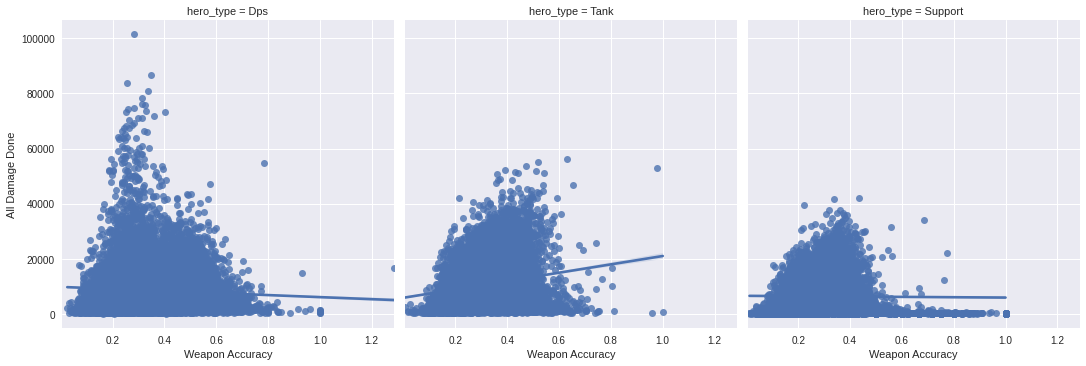

In [85]:
sns.lmplot( data=df_weapon,
    x="Weapon Accuracy", y="All Damage Done", col="hero_type",
    height=5)

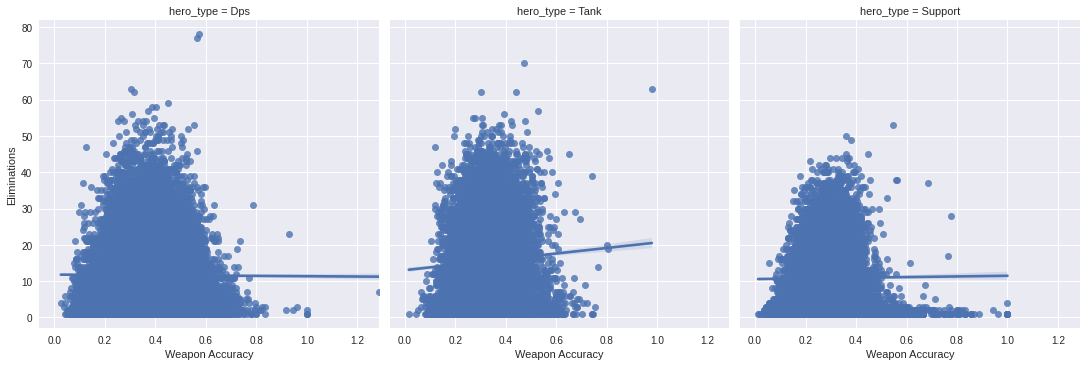

In [86]:
sns.lmplot( data=df_weapon,
    x="Weapon Accuracy", y="Eliminations", col="hero_type",
    height=5)

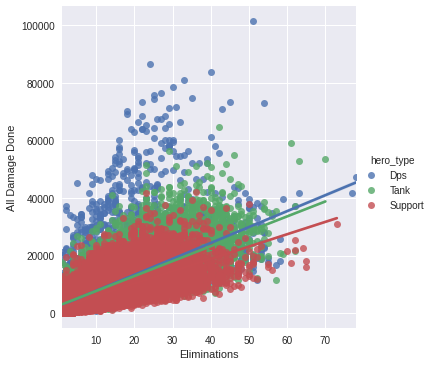

In [87]:
sns.lmplot( data=df_weapon,
    x="Eliminations", y="All Damage Done", hue="hero_type",
    height=5)

No difference in correlation between kills, elims, and weapon accuracy between hero types

In [26]:
asheStats = df[ashe]

In [27]:
_prim = df["stat_name"] == "Damage - Weapon"
_sec = df["stat_name"] == "Damage - Weapon Scoped"
_time = df["stat_name"] == "Time Played"
_dmg = df["stat_name"] == "All Damage Done"
df_ashe_stats = df[(_prim | _sec | _time | _dmg) & ashe]#["stat_amount"]
# prim_dmg = df[prim]['stat_amount'].astype(float)
# prim_dmg.name = 'Primary Damage'
# sec_dmg = asheStats[sec]['stat_amount'].astype(float)
# sec_dmg.name = 'Secondary Damage'
# test = pd.merge(prim_dmg,sec_dmg, left_index=True, right_index=True)
# test
#Cant use asheStats?
#pd.pivot_table(df_ashe_stats, index="player", columns="stat_name", values="stat_amount")
_idx_cols = df_ashe_stats.columns.drop(["stat_name", "stat_amount"])
_cols = "stat_name"
_values = "stat_amount"
df_ashe_stats = pd.pivot(df_ashe_stats, index=_idx_cols, columns=_cols, values=_values).reset_index()

In [28]:
_cols_to_fill = ["All Damage Done", "Damage - Weapon", "Damage - Weapon Scoped"]
df_ashe_stats[_cols_to_fill] = df_ashe_stats[_cols_to_fill].fillna(0)

In [29]:
# compute normalized damage amounts (normalized to time)
for i in _cols_to_fill:
    df_ashe_stats[i + "_normalized"] = df_ashe_stats.apply(
        lambda x: x[i] / x["Time Played"], axis="columns"
    )

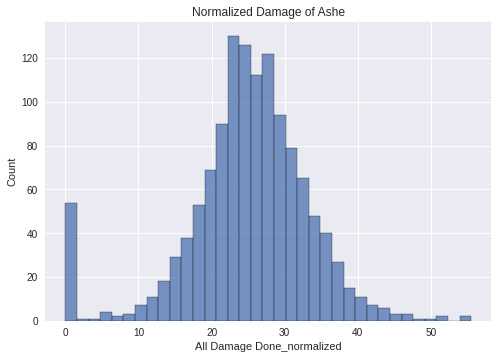

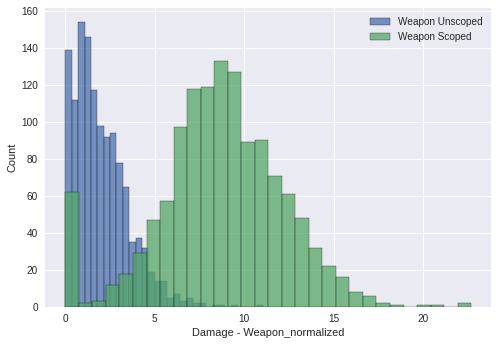

In [30]:
# set plots
sns.histplot(df_ashe_stats, x="All Damage Done_normalized")
plt.title("Normalized Damage of Ashe")

plt.figure()
sns.histplot(df_ashe_stats, x="Damage - Weapon_normalized", label="Weapon Unscoped")
sns.histplot(df_ashe_stats, x="Damage - Weapon Scoped_normalized", color="C1", label="Weapon Scoped")
plt.legend()

In [ ]:
#asheSecondary = (asheStats['stat_name'] == 'Secondary Fire Accuracy')
#for i in range(52660):
   # if (asheStats['stat_name'].iloc[i] == 'Secondary Fire Accuracy'):
       # asheStats['stat_name'].iloc[i] = "Scoped Accuracy"
        #shows an error but works for some reason
        #Also I have no idea why I even made this in the first place


This is a work in progress

# Map Ultimate Data"

In [11]:
df['map_name'].value_counts()

Lijiang Tower            298130
King's Row               280663
Ilios                    270024
Temple of Anubis         267357
Volskaya Industries      263838
Oasis                    259223
Hanamura                 248983
Nepal                    228938
Busan                    220971
Watchpoint: Gibraltar    198073
Numbani                  179979
Dorado                   179902
Blizzard World           179664
Eichenwalde              176617
Junkertown               174954
Hollywood                166672
Route 66                 148811
Horizon Lunar Colony     144123
Havana                   116681
Rialto                   103793
Paris                     84025
Name: map_name, dtype: int64

Paris & Horizon currently out of map pool

Brig zen lucio sombra sym widow not include

Ultimates Used (Self-Destructs not ult used)
ultimates =df"stat_name"
Accecration Kills
Amplification Matrix Assists
Nano Boost Assists
Bob Kills
Self-Destruct Kills 
Meteor Strike Kills
Duplicate Kills
Dragonblade Kills
Dragonstrike Kills
RIP-Tire Kills
Deadeye Kills
Blizzard Kills
Tank Kills
Coalescence Kills
Supercharger Assists
Barrage Kills
Death Blossom Kills
Earthshatter Kills
Whole Hog Kills
Gravitic Flux Kills
Tactical Visor Kills
Molten Core Kills
Pulse Bomb Kills
Primal Rage Kills
Minefield Kills
Graviton Surge Kills

In [8]:
ultimates = (
(df["stat_name"] =='Accecration Kills')
|(df["stat_name"] =='Amplification Matrix Assists')
|(df["stat_name"] =='Nano Boost Assists')
|(df["stat_name"] =='Bob Kills')
|(df["stat_name"] =='Meteor Strike Kills')
|(df["stat_name"] =='Duplicate Kills')
|(df["stat_name"] =='Dragonblade Kills')
|(df["stat_name"] =='Dragonstrike Kills')
|(df["stat_name"] =='RIP-Tire Kills')
|(df["stat_name"] =='Deadeye Kills')
|(df["stat_name"] =='Blizzard Kills')
|(df["stat_name"] =='Tank Kills')
|(df["stat_name"] =='Coalescence Kills')
|(df["stat_name"] =='Supercharger Assists')
|(df["stat_name"] =='Barrage Kills')
|(df["stat_name"] =='Death Blossom Kills')
|(df["stat_name"] =='Earthshatter Kills')
|(df["stat_name"] =='Whole Hog Kills')
|(df["stat_name"] =='Gravitic Flux Kills')
|(df["stat_name"] =='Tactical Visor Kills')
|(df["stat_name"] =='Molten Core Kills')
|(df["stat_name"] =='Pulse Bomb Kills')
|(df["stat_name"] =='Primal Rage Kills')
|(df["stat_name"] =='Minefield Kills')
|(df["stat_name"] =="Graviton Surge Kills")
|(df["stat_name"] =='Ultimates Used')
&(df['hero'] != "All Heroes")
&(df['hero'] != "D.Va")
&(df['hero'] != "Widowmaker")
&(df['hero'] != "Mercy")
&(df['hero'] != "Lúcio")
&(df['hero'] != "Zenyatta")
&(df['hero'] != "Sombra")
&(df['hero'] != "Symmetra")
&(df['hero'] != "Brigitte"))
dvaUlt = ((df["stat_name"] =='Self-Destruct Kills')|(df["stat_name"] =='Self-Destructs'))

In [9]:
def rename_ults(x):
    if x != "Ultimates Used":
        return "Ultimate Kills"
    else:
        return "Ultimates Used"

In [10]:
df_ults = df[ultimates]
df_ults["stat_name"] = df_ults["stat_name"].apply(rename_ults)
df_ults

<ipython-input-10-66565f6d13e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ults["stat_name"] = df_ults["stat_name"].apply(rename_ults)


,start_time,match_id,stage,map_type,map_name,player,team,stat_name,hero,stat_amount
36,1/11/2018 0:12,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Agilities,Los Angeles Valiant,Ultimate Kills,Genji,8.0
55,1/11/2018 0:12,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Agilities,Los Angeles Valiant,Ultimates Used,Genji,8.0
157,1/11/2018 0:12,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Fate,Los Angeles Valiant,Ultimate Kills,Winston,1.0
176,1/11/2018 0:12,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Fate,Los Angeles Valiant,Ultimates Used,Winston,5.0
276,1/11/2018 0:12,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,SoOn,Los Angeles Valiant,Ultimate Kills,Tracer,3.0
...,...,...,...,...,...,...,...,...,...,...
284792,2021-05-23 22:42:27,37273,OWL 2021,ASSAULT,Temple of Anubis,Danteh,Houston Outlaws,Ultimates Used,Echo,2.0
284839,2021-05-23 22:42:27,37273,OWL 2021,ASSAULT,Temple of Anubis,Jake,Houston Outlaws,Ultimate Kills,Junkrat,2.0
284850,2021-05-23 22:42:27,37273,OWL 2021,ASSAULT,Temple of Anubis,Jake,Houston Outlaws,Ultimates Used,Junkrat,1.0
285051,2021-05-23 22:42:27,37273,OWL 2021,ASSAULT,Temple of Anubis,Piggy,Houston Outlaws,Ultimate Kills,Sigma,1.0


In [11]:
df_ults_pivot = pd.pivot_table(df_ults,values=('stat_amount'),
                    index=['map_name','hero'],columns=['stat_name'], aggfunc=np.sum)
df_ults_pivot["Kills per Ult"] = df_ults_pivot.apply(
        lambda x: x["Ultimate Kills"] / x["Ultimates Used"], axis="columns")
df_ults_pivot.to_csv(r'data/ults_data.csv')

In [24]:
df_ults[(df_ults["map_name"] == "Ilios" )&(df_ults["hero"] == "Mei" )]

,start_time,match_id,stage,map_type,map_name,player,team,stat_name,hero,stat_amount
344975,7/12/2019 1:06,20321,Overwatch League Stage 3 Title Matches,CONTROL,Ilios,LiNkzr,Houston Outlaws,Ultimates Used,Mei,1.0
14875,7/26/2019 3:54,21340,Overwatch League Stage 4,CONTROL,Ilios,nero,Guangzhou Charge,Ultimate Kills,Mei,6.0
14916,7/26/2019 3:54,21340,Overwatch League Stage 4,CONTROL,Ilios,nero,Guangzhou Charge,Ultimates Used,Mei,4.0
15403,7/26/2019 3:54,21340,Overwatch League Stage 4,CONTROL,Ilios,eqo,Philadelphia Fusion,Ultimate Kills,Mei,1.0
15438,7/26/2019 3:54,21340,Overwatch League Stage 4,CONTROL,Ilios,eqo,Philadelphia Fusion,Ultimates Used,Mei,2.0
...,...,...,...,...,...,...,...,...,...,...
642398,6/27/2020 9:48,34608,OWL 2020 Regular Season,CONTROL,Ilios,Profit,Seoul Dynasty,Ultimate Kills,Mei,1.0
642432,6/27/2020 9:48,34608,OWL 2020 Regular Season,CONTROL,Ilios,Profit,Seoul Dynasty,Ultimates Used,Mei,1.0
30167,2021-04-17 21:03:15,37231,OWL 2021,CONTROL,Ilios,PELICAN,Atlanta Reign,Ultimates Used,Mei,1.0
133260,2021-04-30 19:05:22,37216,OWL 2021,CONTROL,Ilios,blase,London Spitfire,Ultimate Kills,Mei,2.0
